<a href="https://colab.research.google.com/github/a945120/AIProject/blob/master/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/a945120/AIProject.git

Cloning into 'AIProject'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 193.19 KiB | 2.72 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import yfinance as yf
import pandas as pd
import os

In [19]:
predict_stock = input();

TSM


In [20]:
if os.path.exists("stock.csv"):
  stock = pd.read_csv("stock.csv", index_col=0)
else:
  stock = yf.Ticker(predict_stock)
  stock = stock.history(period="max")
  stock.to_csv("stock.csv")

In [21]:
stock.index = pd.to_datetime(stock.index)

In [22]:
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-10-09 00:00:00-04:00,2.880687,3.348375,2.880687,3.226370,10201979,0.0,0.0
1997-10-10 00:00:00-04:00,3.578830,3.592387,3.246704,3.375488,10669148,0.0,0.0
1997-10-13 00:00:00-04:00,3.382266,3.382266,3.287373,3.300930,3044363,0.0,0.0
1997-10-14 00:00:00-04:00,3.273816,3.280595,3.077252,3.165367,2549907,0.0,0.0
1997-10-15 00:00:00-04:00,2.968802,3.084030,2.962025,3.077252,3167153,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,100.870003,103.330002,100.000000,102.949997,17649500,0.0,0.0
2024-01-18 00:00:00-05:00,111.199997,113.389999,109.480003,113.029999,58783700,0.0,0.0
2024-01-19 00:00:00-05:00,113.220001,115.150002,111.019997,114.199997,37737300,0.0,0.0


<Axes: xlabel='Date'>

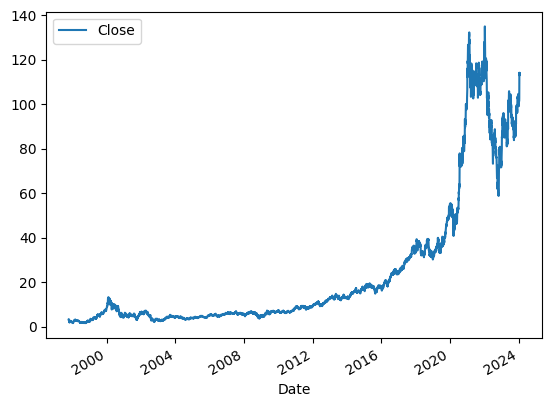

In [23]:
stock.plot.line(y="Close", use_index=True)

In [24]:
del stock["Dividends"]
del stock["Stock Splits"]

In [25]:
stock["Tomorrow"] = stock["Close"].shift(-1)

In [26]:
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

In [27]:
stock = stock.loc["1990-01-01":].copy()

In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [29]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6551724137931034

<Axes: xlabel='Date'>

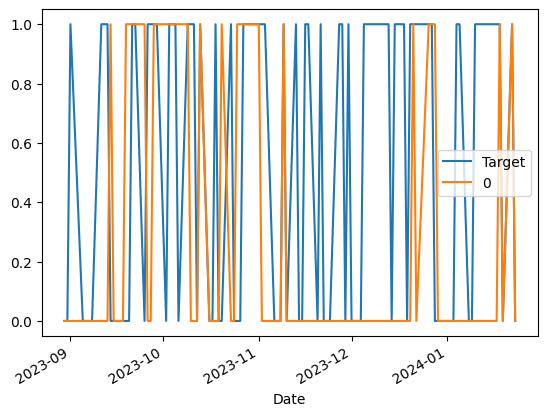

In [30]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [31]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [33]:
predictions = backtest(stock, model, predictors)

In [34]:
predictions["Predictions"].value_counts()

0    3259
1     855
Name: Predictions, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5157894736842106

In [36]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = stock.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

  new_predictors+= [ratio_column, trend_column]

In [37]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])

In [38]:
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2001-10-03 00:00:00-04:00,2.963497,3.393291,2.928836,3.327435,8595717,3.209588,0,1.040650,1.0,1.043705,2.0,0.722511,26.0,0.668639,105.0,0.668370,445.0
2001-10-04 00:00:00-04:00,3.292774,3.382892,3.195724,3.209588,10657723,3.219986,1,0.981972,1.0,0.998490,2.0,0.701586,26.0,0.645790,105.0,0.644720,444.0
2001-10-05 00:00:00-04:00,3.310104,3.317037,3.129868,3.219986,7778304,3.341299,1,1.001617,1.0,1.006064,2.0,0.708079,27.0,0.648762,105.0,0.646820,445.0
2001-10-08 00:00:00-04:00,3.219986,3.445281,3.178394,3.341299,6647939,3.306638,0,1.018489,2.0,1.033448,3.0,0.739094,27.0,0.674146,105.0,0.671165,446.0
2001-10-09 00:00:00-04:00,3.466078,3.486875,3.306638,3.306638,6148924,3.466079,1,0.994786,1.0,1.007817,3.0,0.735752,27.0,0.668282,104.0,0.664172,446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,100.870003,103.330002,100.000000,102.949997,17649500,113.029999,1,1.006255,2.0,1.013527,4.0,1.056194,35.0,1.105635,124.0,1.139922,500.0
2024-01-18 00:00:00-05:00,111.199997,113.389999,109.480003,113.029999,58783700,114.199997,1,1.046671,2.0,1.086597,5.0,1.155233,36.0,1.212519,125.0,1.250696,500.0
2024-01-19 00:00:00-05:00,113.220001,115.150002,111.019997,114.199997,37737300,113.029999,0,1.005149,2.0,1.071114,5.0,1.162534,37.0,1.223762,125.0,1.262782,500.0


In [39]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [40]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >=.6] = 1
  preds[preds <.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [41]:
predictions = backtest(stock, model, new_predictors)

In [42]:
predictions["Predictions"].value_counts()

0.0    2919
1.0     195
Name: Predictions, dtype: int64

In [43]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5076923076923077

In [44]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.515414
0    0.484586
Name: Target, dtype: float64

In [45]:
predictions

,Target,Predictions
Date,,
2011-09-07 00:00:00-04:00,0,0.0
2011-09-08 00:00:00-04:00,0,0.0
2011-09-09 00:00:00-04:00,1,0.0
2011-09-12 00:00:00-04:00,1,0.0
2011-09-13 00:00:00-04:00,0,0.0
...,...,...
2024-01-17 00:00:00-05:00,1,0.0
2024-01-18 00:00:00-05:00,1,0.0
2024-01-19 00:00:00-05:00,0,0.0
